# Redes sociais - P1
Fernando Fincatti, Gabriela Moreno, Gabriella Cukier e Manuel Castanares

---

### Importando bibliotecas
---

In [1]:
import netpixi
from netpixi.data.gt import *
import cpnet
from graph_tool import spectral
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
sns.set()
from matplotlib import rcParams
import statsmodels.formula.api as smf
import csv
import pandas as pd
from graph_tool import util
from graph_tool import Graph
from utils import *
from graph_tool import clustering

### Carrega dados
---

In [2]:
#carrega dados
df = pd.read_csv('athlete_events.csv')
df_noc = pd.read_csv('noc_regions.csv')
df_gdp = pd.read_csv('countries of the world.csv')

In [3]:
df.head(2)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN


In [4]:
df_noc.head(2)

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles


In [5]:
df_gdp.head(2)

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"


In [6]:
#junta ambas as tabelas
df_merge=df.merge(df_noc,how="left",on="NOC")

#dropa linhas sem a região
df_merge=df_merge.dropna(subset=['region'])

In [7]:
df_merge.head(2)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN


### Amostragem
---

In [8]:
#filtra somente datas posteriores a 1970
df_merge=df_merge[df_merge["Year"] > 1970]

### Análise
---

In [9]:
#cria grafo não-dirigido
g = Graph(directed=False)
c = Graph(directed=False) 

In [10]:
df_merge['desempenho'] = df_merge['Medal'].apply(lambda x: desempenho(x))

In [11]:
#dropa valores duplicados
df_desempenho = df_merge.drop_duplicates(subset=["Year","Sport","region"])

#remove paises com desempenho 0
df_desempenho = df_desempenho.loc[df_desempenho.desempenho>0]

In [12]:
#pega o desempenho por país por esporte
df_desempenho_pais = df_desempenho[["Sport", "region", "desempenho"]].groupby(["Sport", "region"], as_index=False).sum()

#calcula o desemepnho médio por esporte
df_desempenho_media = df_desempenho_pais.groupby(["Sport"]).mean()

In [13]:
#adiciona o desempenho médio por esporte na tabela
df_desempenho_pais["media"] = df_desempenho_pais["Sport"].apply(lambda x: 
              media(x, df_desempenho_media))

In [14]:
#ajusta nome dos países na tabela
df_gdp['Country'] = df_gdp['Country'].apply(lambda x: elimina_ultimo_caracter(x))

In [15]:
#dicionário com os nomes corretos
dic_paises_nome = {
    'South Korea': 'Korea, South',
    'USA': 'United States',
    'UK': 'United Kingdom',
    'North Korea': 'Korea, North',
    'Ivory Coast': "Cote d'Ivoire"
}

In [16]:
#acerta o nome dos países
df_desempenho_pais['region'] = df_desempenho_pais['region'].apply(lambda x: acerta_nome_paises(x, dic_paises_nome)) 

In [17]:
#pega informações sobre cada país
df_desempenho_pais = df_desempenho_pais.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

In [18]:
#remove alguns países irrelevantes
df_desempenho_pais = df_desempenho_pais.dropna(subset=['GDP ($ per capita)'])

In [19]:
#pega todos os times
lista_teams = df_desempenho_pais.region.unique().tolist()

#pega todos os eventos
lista_eventos = df_desempenho_pais.Sport.unique().tolist()

In [20]:
g.vp['tipo'] = g.new_vp('object')
g.vp['nome'] = g.new_vp('object')
g.vp['color'] = g.new_vp('object')

In [21]:
lista_vertices = lista_teams+lista_eventos

In [22]:
#cria os times como vértices
cria_vertices(g, lista_vertices, len(lista_teams))
print('número de vértices de g:', g.num_vertices())

número de vértices de g: 148


In [23]:
lista_arestas = list()

#preenche a lista e o dicionario de acordo com as partidas e ocorrencias
df_fake = df_desempenho_pais.apply(lambda x: 
              arestas(x.region, x.Sport, x.desempenho, x.media, lista_arestas),
              axis=1)

In [24]:
create_edgs_links(lista_arestas, g)

### Análise 2
---

In [25]:
c.vp['nome'] = c.new_vp('object') #adiciona propriedade aos vértices
c.ep['peso'] = c.new_ep('object') #adiciona propriedade as arestas

In [26]:
cria_nome_times(g, c) #cria vertíces

In [27]:
dicionario_one_mode, lista_one_mode = lista_esporte_por_time(g)

In [28]:
dist = cria_arestas(c, dicionario_one_mode, lista_one_mode)

### Visualizando grafo C
---

In [29]:
m = draw_gt.sfdp_layout(c)
move_gt(c, m)

In [30]:
save_gt(c, 'exemplo_c.net.gz')

In [31]:
r = netpixi.render('./exemplo_c.net.gz', infinite=True)

### Cluster coefficient
---

In [32]:
cluster = clustering.local_clustering(c)

In [33]:
c.vp['clustering coefficient'] = cluster

In [34]:
dft = pd.DataFrame({k: list(v) for k, v in c.vp.items()})

In [35]:
dft = dft.loc[dft['clustering coefficient'] != 0]

### Salvando grafo e visualizando
---

In [36]:
top = []
for v in g.vertices():
    if g.vp['tipo'][v] == 'time':
        top.append(v)

In [37]:
m = draw_gt.bipartite_layout(g, top)
move_gt(g, m)

In [38]:
save_gt(g, 'exemplo.net.gz')

In [39]:
r = netpixi.render('./exemplo.net.gz')

In [40]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x000000, size=10)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0x000000, width=1, curve1=0, curve2=0)

# mudar uma aresta específica a partir dos ids de sua origem e destino
r.edge(0, 1, color=0x0000ff, width=2)

### Regressão
---

In [41]:
df_desempenho_pais_total = df_desempenho[["region", "desempenho"]].groupby(["region"], as_index=False).sum()

In [42]:
df_desempenho_pais_total = df_desempenho_pais_total.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country")

df_desempenho_pais_total = df_desempenho_pais_total.merge(dft,
                                              how='left',
                                              left_on="region",
                                              right_on="nome")

In [43]:
df_desempenho_pais_total

,region,desempenho,Country,GDP ($ per capita),nome,_x,_y,clustering coefficient
0,Algeria,1,Algeria,6000.0,Algeria,8.270033,6.367632,1.000000
1,Argentina,26,Argentina,11200.0,Argentina,6.096368,6.116861,0.772300
2,Armenia,5,Armenia,3500.0,Armenia,0.010783,6.085276,0.934461
3,Australia,82,Australia,29000.0,Australia,3.846306,6.897803,0.695857
4,Austria,25,Austria,30000.0,Austria,1.683590,5.741017,0.895877
...,...,...,...,...,...,...,...,...
96,Uzbekistan,8,Uzbekistan,1700.0,Uzbekistan,2.540399,5.989296,0.904150
97,Venezuela,2,Venezuela,4800.0,Venezuela,7.518955,8.614479,0.909774
98,Vietnam,5,Vietnam,2500.0,Vietnam,0.848138,5.201958,0.911406
99,Zambia,2,Zambia,800.0,Zambia,0.992188,12.682518,1.000000


In [44]:
df_desempenho_pais_total['y'] = df_desempenho_pais_total['GDP ($ per capita)']
df_desempenho_pais_total['c'] = df_desempenho_pais_total['clustering coefficient']

In [45]:
model = smf.ols(data=df_desempenho_pais_total, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     17.99
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           5.33e-05
Time:                        20:44:51   Log-Likelihood:                -459.55
No. Observations:                  93   AIC:                             923.1
Df Residuals:                      91   BIC:                             928.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1337      5.308      1.344      0.182      -3.410      17.678
y              0.0015      0.000      4.241      0.000       0.001       0.002
==============================================================================
Omnibus:                      112.319   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2196.977
Skew:                           3.948   Prob(JB):                         0.00
Kurtosis:                      25.464   Cond. No.                     2.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

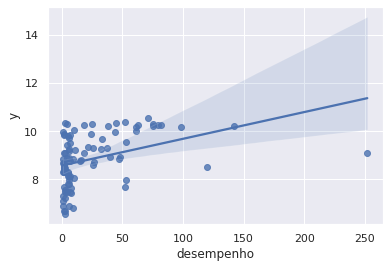

In [46]:
sns.regplot(x=df_desempenho_pais_total['desempenho'], y=np.log(df_desempenho_pais_total['y']))
plt.show()

In [47]:
df_desempenho_cluster = df_desempenho_pais_total.dropna(subset=['clustering coefficient'])

In [48]:
df_desempenho_cluster.shape

(93, 10)

In [49]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     94.76
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           9.17e-16
Time:                        20:44:55   Log-Likelihood:                -434.75
No. Observations:                  93   AIC:                             873.5
Df Residuals:                      91   BIC:                             878.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    201.5400     18.453     10.922      0.000     164.885     238.195
c           -207.8944     21.357     -9.734      0.000    -250.317    -165.471
==============================================================================
Omnibus:                       96.393   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1585.334
Skew:                           3.155   Prob(JB):                         0.00
Kurtosis:                      22.217   Cond. No.                         13.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

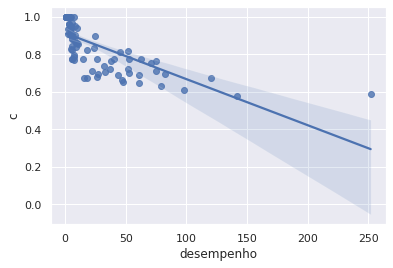

In [50]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=df_desempenho_cluster['c'])
plt.show()

### Conclusão
---

Com base na regressão feita acima, podemos ver que o coeficiente é muito pequeno. O $R^2$ obtido também é muito pequeno, mostrando que não há um bom fit entre as duas variáveis. Além disso, os valores para o eixo X (desempenho) também são muito parecidos, o que faz o gráfico ficar "empilhado", isso é possível confirmar apartir da visualização acima. Portanto podemos rejeitar a hipótese de que mais riqueza signifca mais desempenho.